In [2]:
import pandas as pd

mortality_df = pd.read_csv('mortality.csv')
time_series_df = pd.read_csv('vital_time_series.csv')

total_df = pd.merge(time_series_df, mortality_df, on='icustay_id')

In [ ]:
total_df.to_csv('data.csv', index=False)

In [3]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50136 entries, 0 to 50135
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   icustay_id   50136 non-null  int64  
 1   hr           50136 non-null  int64  
 2   heartrate    46815 non-null  float64
 3   sysbp        45134 non-null  float64
 4   diasbp       45130 non-null  float64
 5   meanbp       45309 non-null  float64
 6   resprate     46226 non-null  float64
 7   spo2         45610 non-null  float64
 8   urineoutput  33336 non-null  float64
 9   mortality    50136 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 4.2 MB


# Data Analysis

In [9]:
non_nan_df = total_df.dropna()
non_nan_df_class_0 = non_nan_df[non_nan_df['mortality'] == 0]
non_nan_df_class_1 = non_nan_df[non_nan_df['mortality'] == 1]

In [10]:
def avg_df(df):
  length = len(df)
  total_patients = length // 24
  df_grouped = pd.DataFrame(index=range(24), columns=df.columns)
  for i in range(24):
      df_grouped.iloc[i] = df.iloc[i::24].sum()

  # divide the values by 10 to get the averages
  df_averaged = df_grouped / total_patients

  return df_averaged

In [11]:
non_nan_df_class_0_avg = avg_df(non_nan_df_class_0)
non_nan_df_class_1_avg = avg_df(non_nan_df_class_1)

In [12]:
non_nan_df_class_0_avg = non_nan_df_class_0_avg.drop(['icustay_id', 'hr', 'mortality'], axis=1)
non_nan_df_class_1_avg = non_nan_df_class_1_avg.drop(['icustay_id', 'hr', 'mortality'], axis=1)

IndexError: ignored

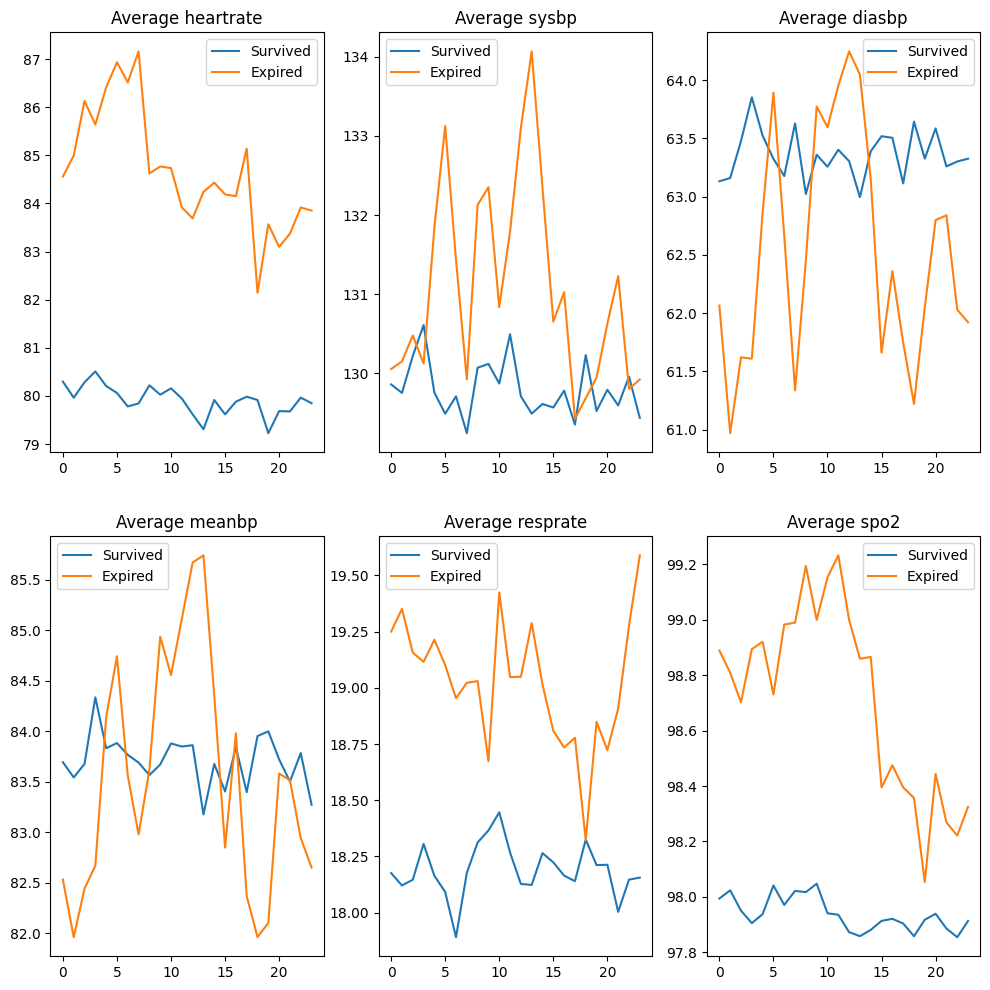

In [63]:
import matplotlib.pyplot as plt
import numpy as np
# create 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 12))


# plot each column in each subplot
for i, col in enumerate(non_nan_df_class_0_avg.columns):
    axs_flat = axs.flatten()
    axs_flat[i].plot(non_nan_df_class_0_avg[col], label='Survived')
    axs_flat[i].plot(non_nan_df_class_1_avg[col], label='Expired')
    axs_flat[i].set_title('Average ' + col)
    axs_flat[i].legend()


# show the plots
plt.show()

# Data Imputation

In [14]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(total_df)
total_df_imputed = imputer.transform(total_df)
total_df_imputed = pd.DataFrame(total_df_imputed, columns=total_df.columns)

In [15]:
total_df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50136 entries, 0 to 50135
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   icustay_id   50136 non-null  float64
 1   hr           50136 non-null  float64
 2   heartrate    50136 non-null  float64
 3   sysbp        50136 non-null  float64
 4   diasbp       50136 non-null  float64
 5   meanbp       50136 non-null  float64
 6   resprate     50136 non-null  float64
 7   spo2         50136 non-null  float64
 8   urineoutput  50136 non-null  float64
 9   mortality    50136 non-null  float64
dtypes: float64(10)
memory usage: 3.8 MB


In [16]:
total_df.to_csv('data_imputed.csv', index=False)

# Feature Extraction

In [ ]:
!pip install --upgrade tsfresh

In [22]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas(desc='My bar!')
import numpy as np
import time
import matplotlib.pyplot as plt
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [26]:

from tsfresh.feature_extraction import extract_features, MinimalFCParameters

extracted_features = extract_features(
    total_df_imputed.drop(['mortality'], axis=1),
    column_id="icustay_id",
    column_sort="hr",
    default_fc_parameters=MinimalFCParameters()
)
extracted_features = extracted_features.rename_axis('icustay_id').reset_index()
extracted_features['icustay_id'] = extracted_features['icustay_id'].astype(int)

Feature Extraction: 100%|██████████| 14623/14623 [00:09<00:00, 1541.43it/s]


In [ ]:
extracted_features.info()

# All features

In [ ]:
extracted_features = extract_features(total_df_imputed.drop(['mortality'], axis=1), column_id="icustay_id", column_sort="hr")

Feature Extraction: 100%|██████████| 14623/14623 [11:16<00:00, 21.62it/s]


In [ ]:
extracted_features = extracted_features.rename_axis('icustay_id').reset_index()

In [ ]:
extracted_features['icustay_id'] = extracted_features['icustay_id'].astype(int)
extracted_features['icustay_id']

In [ ]:
extracted_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Columns: 5482 entries, icustay_id to urineoutput__mean_n_absolute_max__number_of_maxima_7
dtypes: float64(5481), int64(1)
memory usage: 87.4 MB


In [ ]:
impute(extracted_features)

In [28]:
tabular_df = pd.merge(mortality_df, extracted_features, on='icustay_id')

In [29]:
tabular_df.describe()

,icustay_id,mortality,heartrate__sum_values,heartrate__median,heartrate__mean,heartrate__length,heartrate__standard_deviation,heartrate__variance,heartrate__root_mean_square,heartrate__maximum,...,urineoutput__sum_values,urineoutput__median,urineoutput__mean,urineoutput__length,urineoutput__standard_deviation,urineoutput__variance,urineoutput__root_mean_square,urineoutput__maximum,urineoutput__absolute_maximum,urineoutput__minimum
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.0,2089.000000,2089.000000,2089.000000,2089.000000,...,2089.000000,2089.000000,2089.000000,2089.0,2089.000000,2.089000e+03,2089.000000,2089.000000,2089.000000,2089.000000
mean,249063.705122,0.146960,1924.042575,79.519956,80.168441,24.0,7.961047,77.094276,80.636044,97.459376,...,3816.363523,137.187841,159.015147,24.0,95.275450,5.990404e+04,191.486209,471.653135,471.653135,50.794734
std,29087.060370,0.354151,332.983309,14.273530,13.874305,0.0,3.704400,85.115443,13.942697,17.698197,...,3199.111226,113.775932,133.296301,0.0,225.501605,1.994267e+06,257.515116,1105.176411,1105.176411,98.246019
min,200039.000000,0.000000,1061.633333,41.000000,44.234722,24.0,0.000000,0.000000,44.519308,51.000000,...,0.000000,0.000000,0.000000,24.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-3250.000000
25%,223790.000000,0.000000,1696.200000,70.000000,70.675000,24.0,5.469585,29.916365,71.015540,85.000000,...,2000.000000,65.000000,83.333333,24.0,42.461797,1.803004e+03,98.334463,220.000000,220.000000,20.000000
50%,248142.000000,0.000000,1894.300000,78.500000,78.929167,24.0,7.262920,52.750000,79.257799,96.000000,...,3120.000000,107.500000,130.000000,24.0,72.007125,5.185026e+03,157.763536,350.000000,350.000000,35.000000
75%,273890.000000,0.000000,2126.600000,88.000000,88.608333,24.0,9.636087,92.854167,89.102740,108.000000,...,4736.000000,171.000000,197.333333,24.0,108.796031,1.183658e+04,233.001660,525.000000,525.000000,60.000000
max,299973.000000,1.000000,3326.510000,144.500000,138.604583,24.0,31.296736,979.485677,139.262653,183.000000,...,72055.000000,1502.000000,3002.291667,24.0,9544.165449,9.109109e+07,10005.241095,47050.000000,47050.000000,1502.000000


In [30]:
tabular_df.to_csv('medical_ai_tabular_df_minimal.csv', index=False)

In [17]:
tabular_df = pd.read_csv('medical_ai_tabular_df.csv')

# Plain train-test

In [49]:
# Import libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
random_state = 0

# Split data into train and test sets
X = tabular_df.drop('mortality', axis=1)
y = tabular_df['mortality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Oversample training data
oversampler = SMOTE(random_state=random_state)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
avg_prc = average_precision_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('ROC AUC:', roc_auc)
print('Avg Precision:', avg_prc)

Accuracy: 0.8261562998405104
Precision: 0.31666666666666665
Recall: 0.21839080459770116
F1 Score: 0.25850340136054417
ROC AUC: 0.5712324393358876
Avg Precision: 0.17761003868081907


# K-fold cross validation

In [50]:
# Import libraries
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
random_state = 0

# Split data into features and target
X = tabular_df.drop('mortality', axis=1)
y = tabular_df['mortality']

# Initialize k-fold cross-validator
n_splits = 5  # You can change this value to the desired number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize lists to store evaluation metrics from each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
avg_prcs = []

# Perform k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Oversample training data with SMOTE
    oversampler = SMOTE(random_state=random_state)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # Train XGBoost model
    model = xgb.XGBClassifier(random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics for this fold
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    avg_prc = average_precision_score(y_test, y_pred)

    # Append metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    avg_prcs.append(avg_prc)

# Calculate average metrics across all folds
avg_accuracy = sum(accuracies) / len(accuracies)
avg_precision = sum(precisions) / len(precisions)
avg_recall = sum(recalls) / len(recalls)
avg_f1 = sum(f1_scores) / len(f1_scores)
avg_roc_auc = sum(roc_aucs) / len(roc_aucs)
avg_avg_prc = sum(avg_prcs) / len(avg_prcs)

# Print the average evaluation metrics
print('Average Accuracy:', avg_accuracy)
print('Average Precision:', avg_precision)
print('Average Recall:', avg_recall)
print('Average F1 Score:', avg_f1)
print('Average ROC AUC:', avg_roc_auc)
print('Average Avg Precision:', avg_avg_prc)


Average Accuracy: 0.8061260082842816
Average Precision: 0.2914663065674198
Average Recall: 0.21507139079851934
Average F1 Score: 0.24595622216723134
Average ROC AUC: 0.5615217842168091
Average Avg Precision: 0.17795817319932847


# Balnacing data

In [51]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
random_state=0
# Split data into majority and minority classes
df_majority = tabular_df[tabular_df['mortality'] == 0]
df_minority = tabular_df[tabular_df['mortality'] == 1]

# Undersample majority class
# Get minority class size
minority_size = len(df_minority)

# Undersample majority to 55% of minority size
majority_undersample_size = int(0.6 * minority_size)

df_majority_under = resample(df_majority,
                              replace=False,
                              n_samples=majority_undersample_size,
                              random_state=random_state)
# Concatenate balanced data
balanced_df = pd.concat([df_majority_under, df_minority])

# Split balanced data into train-test sets
X = balanced_df.drop('mortality', axis=1)
y = balanced_df['mortality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

# Train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Evaluate metrics on test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
avg_prc = average_precision_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('ROC AUC:', roc_auc)
print('Avg Precision:', avg_prc)

Accuracy: 0.7106598984771574
Precision: 0.7379310344827587
Recall: 0.8492063492063492
F1 Score: 0.7896678966789668
ROC AUC: 0.6569975408003577
Avg Precision: 0.7231024202667822


# Balanced K-fold

In [54]:
# Import libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
random_state = 0
# Split data into majority and minority classes
df_majority = tabular_df[tabular_df['mortality'] == 0]
df_minority = tabular_df[tabular_df['mortality'] == 1]

# Undersample majority class
# Get minority class size
minority_size = len(df_minority)

# Undersample majority to 55% of minority size
majority_undersample_size = int(0.55 * minority_size)

df_majority_under = resample(df_majority,
                              replace=False,
                              n_samples=majority_undersample_size,
                              random_state=random_state)
# Concatenate balanced data
balanced_df = pd.concat([df_majority_under, df_minority])

# Split balanced data into features and target
X = balanced_df.drop('mortality', axis=1)
y = balanced_df['mortality']

# Initialize k-fold cross-validator
n_splits = 5  # You can change this value to the desired number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize lists to store evaluation metrics from each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
avg_prcs = []

# Perform k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train XGBoost model
    model = xgb.XGBClassifier(random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics for this fold
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    avg_prc = average_precision_score(y_test, y_pred)

    # Append metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    avg_prcs.append(avg_prc)

# Calculate average metrics across all folds
avg_accuracy_balanced = sum(accuracies) / len(accuracies)
avg_precision_balanced = sum(precisions) / len(precisions)
avg_recall_balanced = sum(recalls) / len(recalls)
avg_f1_balanced = sum(f1_scores) / len(f1_scores)
avg_roc_auc_balanced = sum(roc_aucs) / len(roc_aucs)
avg_avg_prc_balanced = sum(avg_prcs) / len(avg_prcs)

# Print the average evaluation metrics
print('Average Accuracy:', avg_accuracy_balanced)
print('Average Precision:', avg_precision_balanced)
print('Average Recall:', avg_recall_balanced)
print('Average F1 Score:', avg_f1_balanced)
print('Average ROC AUC:', avg_roc_auc_balanced)
print('Average Avg Precision:', avg_avg_prc_balanced)


Average Accuracy: 0.7136842105263158
Average Precision: 0.7484990752596387
Average Recall: 0.8404019037546272
Average F1 Score: 0.791673455367121
Average ROC AUC: 0.6608426631072601
Average Avg Precision: 0.7326903721686044


# Hyper parameter tuning

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import resample
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
random_state = 0
# Split data into majority and minority classes
df_majority = tabular_df[tabular_df['mortality'] == 0]
df_minority = tabular_df[tabular_df['mortality'] == 1]

# Undersample majority class
# Get minority class size
minority_size = len(df_minority)

# Undersample majority to 55% of minority size
majority_undersample_size = int(0.6 * minority_size)

df_majority_under = resample(df_majority,
                              replace=False,
                              n_samples=majority_undersample_size,
                              random_state=random_state)
# Concatenate balanced data
balanced_df = pd.concat([df_majority_under, df_minority])

# Split balanced data into train-test sets
X = balanced_df.drop('mortality', axis=1)
y = balanced_df['mortality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

# ... (existing code) ...

# Hyperparameter tuning for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='f1',  # Use accuracy as the evaluation metric
    cv=5,  # 5-fold cross-validation
    random_state=42,  # Random seed for reproducibility
    n_jobs=-1,  # Use all available CPU cores
)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters found by the search
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

# Evaluate metrics on test set
y_pred = best_xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
avg_prc = average_precision_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('ROC AUC:', roc_auc)
print('Avg Precision:', avg_prc)


Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Accuracy: 0.7411167512690355
Precision: 0.7551020408163265
Recall: 0.8809523809523809
F1 Score: 0.8131868131868131
ROC AUC: 0.6869550637156271
Avg Precision: 0.7413510726988402


Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


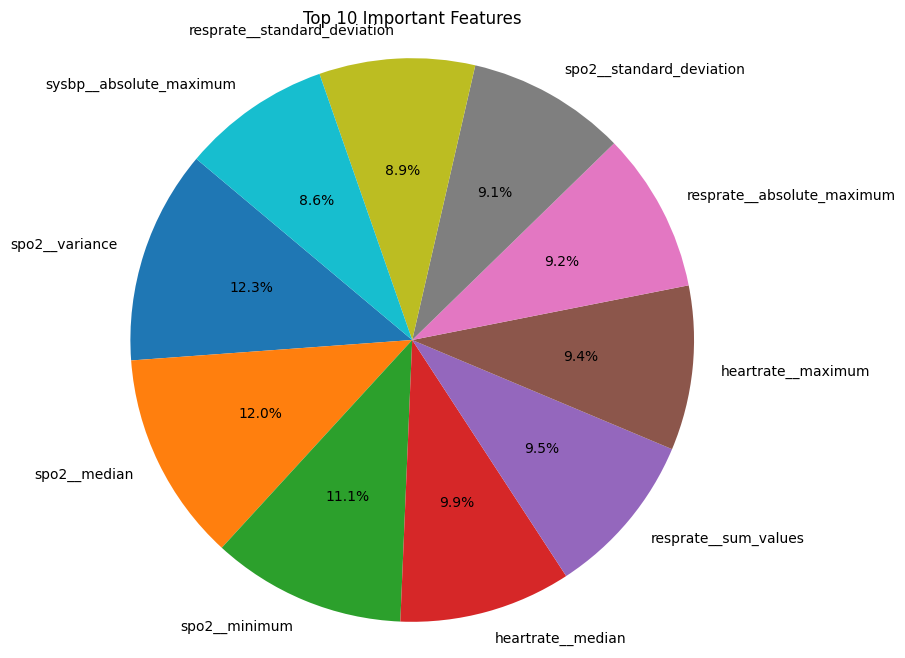

In [62]:
# Get the best hyperparameters found by the search
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

# Get feature importances from the best model
importance_scores = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a dictionary to store feature names and their corresponding importance scores
feature_importance_dict = {feature_name: importance_score for feature_name, importance_score in zip(feature_names, importance_scores)}

# Sort the features based on importance scores in descending order and get the top 10 features
top_10_features = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)[:10])

# Create a pie chart with seaborn
plt.figure(figsize=(8, 8))
plt.pie(top_10_features.values(), labels=top_10_features.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Important Features')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


# Plotting

In [56]:
# Store the average evaluation metrics for each method
methods = ['Imbalanced Data', 'Balanced Data (Undersampling)', 'Hyperparameter Tuned (Balanced)']

imbalanced_metrics = [avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc, avg_avg_prc]
balanced_metrics = [avg_accuracy_balanced, avg_precision_balanced, avg_recall_balanced, avg_f1_balanced, avg_roc_auc_balanced, avg_avg_prc_balanced]
tuned_metrics = [accuracy, precision, recall, f1, roc_auc, avg_prc]

all_metrics = [imbalanced_metrics, balanced_metrics, tuned_metrics]

<ipython-input-61-054a1a4844cc>:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Metric', y='Score', hue='Method', data=df_melted, ci=None)


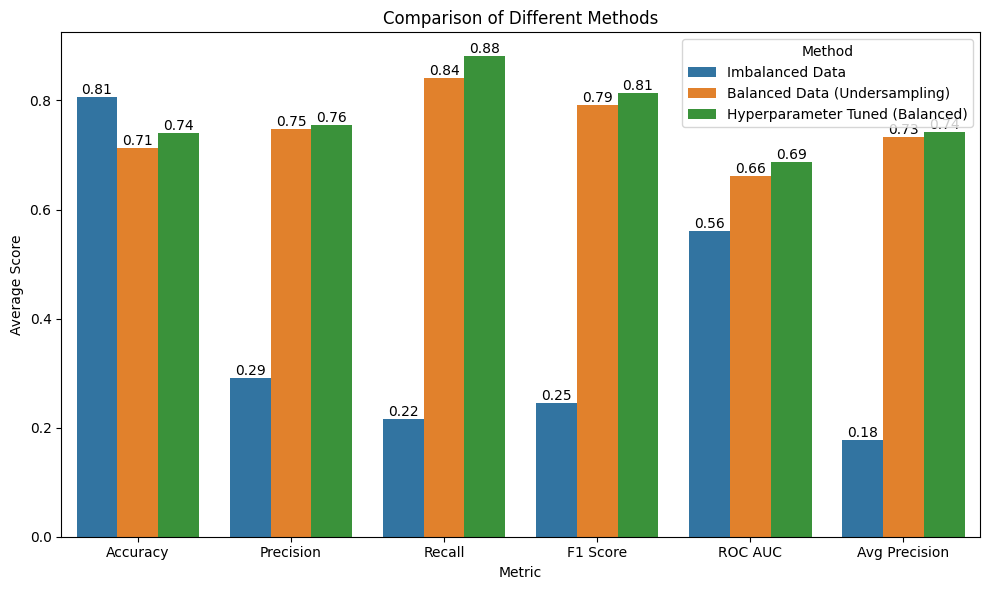

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Store the average evaluation metrics for each method
methods = ['Imbalanced Data', 'Balanced Data (Undersampling)', 'Hyperparameter Tuned (Balanced)']

# Replace the lists with dictionaries, with metrics as keys and values as lists
imbalanced_metrics = {
    'Accuracy': avg_accuracy,
    'Precision': avg_precision,
    'Recall': avg_recall,
    'F1 Score': avg_f1,
    'ROC AUC': avg_roc_auc,
    'Avg Precision': avg_avg_prc
}
balanced_metrics = {
    'Accuracy': avg_accuracy_balanced,
    'Precision': avg_precision_balanced,
    'Recall': avg_recall_balanced,
    'F1 Score': avg_f1_balanced,
    'ROC AUC': avg_roc_auc_balanced,
    'Avg Precision': avg_avg_prc_balanced
}
tuned_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc,
    'Avg Precision': avg_prc
}

# Fill missing metrics with NaN
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Avg Precision']
for method_metrics in [imbalanced_metrics, balanced_metrics, tuned_metrics]:
    for label in metrics_labels:
        if label not in method_metrics:
            method_metrics[label] = np.nan

# Store all the metrics dictionaries in a list
all_metrics = [imbalanced_metrics, balanced_metrics, tuned_metrics]

# Create the dataframe directly from the list of dictionaries
df = pd.DataFrame(all_metrics, index=methods)

# Melt the dataframe to make it suitable for plotting with seaborn
df_melted = df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
df_melted = df_melted.rename(columns={'index': 'Method'})

# Create the bar plot with seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Score', hue='Method', data=df_melted, ci=None)

# Display the values above each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

# Set the y-axis label
plt.ylabel('Average Score')

# Set the plot title
plt.title('Comparison of Different Methods')

# Display the legend
plt.legend(title='Method', loc='upper right')

plt.tight_layout()
plt.show()
